## imports

In [13]:
import os

import numpy as np
import torch
import torchvision
from matplotlib import pyplot as plt

from code.src.utils.common import get_model_resnet18_cifar10, get_loader, create_saved_data_dir, get_device
from code.src.utils.dataset import get_cifar10
from code.src.utils.plot import plot_prune_example, compare_models_losses
from code.src.utils.train import Mode, run_epoch, train


## globals

In [14]:
NUM_CLASSES = 10
BATCH_SIZE = 5
NUM_TRAIN = 30
NUM_VALID = 20
NUM_TEST = 20
EPOCHS = 2
ENSEMBLE_SIZE = 1

DEVICE = get_device()
PATH_MODELS_SAVE = create_saved_data_dir(os.path.join(os.path.abspath(''), 'research', 'el2n_resnet18_cifar10.ipynb'))

CUDA is not available.  Training on CPU...


## data loaders, models

In [15]:
# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
data_train, data_test = get_cifar10(os.path.abspath(os.path.join('../../../', 'datasets')))
loader_train = get_loader(data_train, np.arange(NUM_TRAIN), BATCH_SIZE)
loader_train_ordered = get_loader(data_train, np.arange(NUM_TRAIN), BATCH_SIZE, shuffle=False)
loader_valid = get_loader(data_train, np.arange(NUM_TRAIN, NUM_VALID + NUM_TRAIN), BATCH_SIZE)
loader_test = get_loader(data_test, np.arange(NUM_TEST), BATCH_SIZE)

model, criterion, optimizer = get_model_resnet18_cifar10()
epochs_pred = torch.empty((EPOCHS, NUM_TRAIN), dtype=torch.int8)
change_counter = torch.zeros(NUM_TRAIN, dtype=torch.int8)

Files already downloaded and verified
Files already downloaded and verified


## train

In [16]:
print()
for epoch in range(EPOCHS):
    train_res = run_epoch(model, criterion, optimizer, loader_train, NUM_CLASSES, DEVICE, Mode.TRAIN)
    valid_res = run_epoch(model, criterion, optimizer, loader_valid, NUM_CLASSES, DEVICE, Mode.VALIDATE)
    scores_train, pred_train, loss_train, acc_train = train_res
    scores_valid, pred_valid, loss_valid, acc_valid = valid_res
    print(f'Epoch: {epoch} Training: Loss: {loss_train:.6f} Acc: {acc_train:.6f}  '
          f'Validation Loss: {loss_valid:.6f} Acc: {acc_valid:.6f}  ', end='')

    train_res = run_epoch(model, criterion, optimizer, loader_train_ordered, NUM_CLASSES, DEVICE, Mode.TEST)
    epochs_pred[epoch] = train_res[1].detach().clone()
    if epoch:
        changes = torch.Tensor(epochs_pred[epoch - 1] != epochs_pred[epoch])
        print(f'Changes {changes.type(torch.float64).mean()}')
        change_counter += changes
    else:
        print()

torch.save(model.state_dict(), PATH_MODELS_SAVE('model.pt'))
torch.save(epochs_pred, PATH_MODELS_SAVE('epochs_pred.pt'))
torch.save(change_counter, PATH_MODELS_SAVE('change_counter.pt'))


Epoch: 0 Training: Loss: 0.532917 Acc: 0.066667  Validation Loss: 0.470579 Acc: 0.000000  
Epoch: 1 Training: Loss: 0.541918 Acc: 0.100000  Validation Loss: 0.475326 Acc: 0.050000  Changes 0.5333333333333333


## Plot histogram of changes for each train example

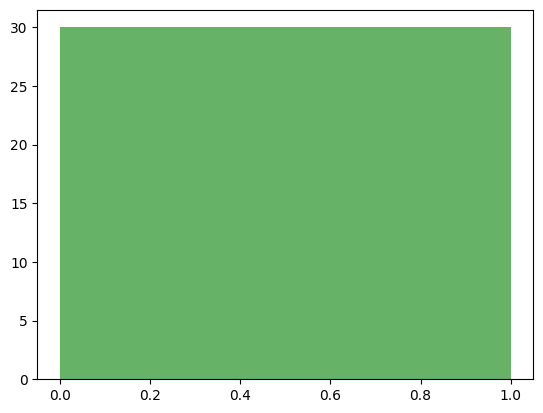

In [17]:
plt.hist(change_counter, bins=EPOCHS - 1, facecolor='g', alpha=0.6)
plt.show()

## Plot the hardest/easiest examples according to EL2N

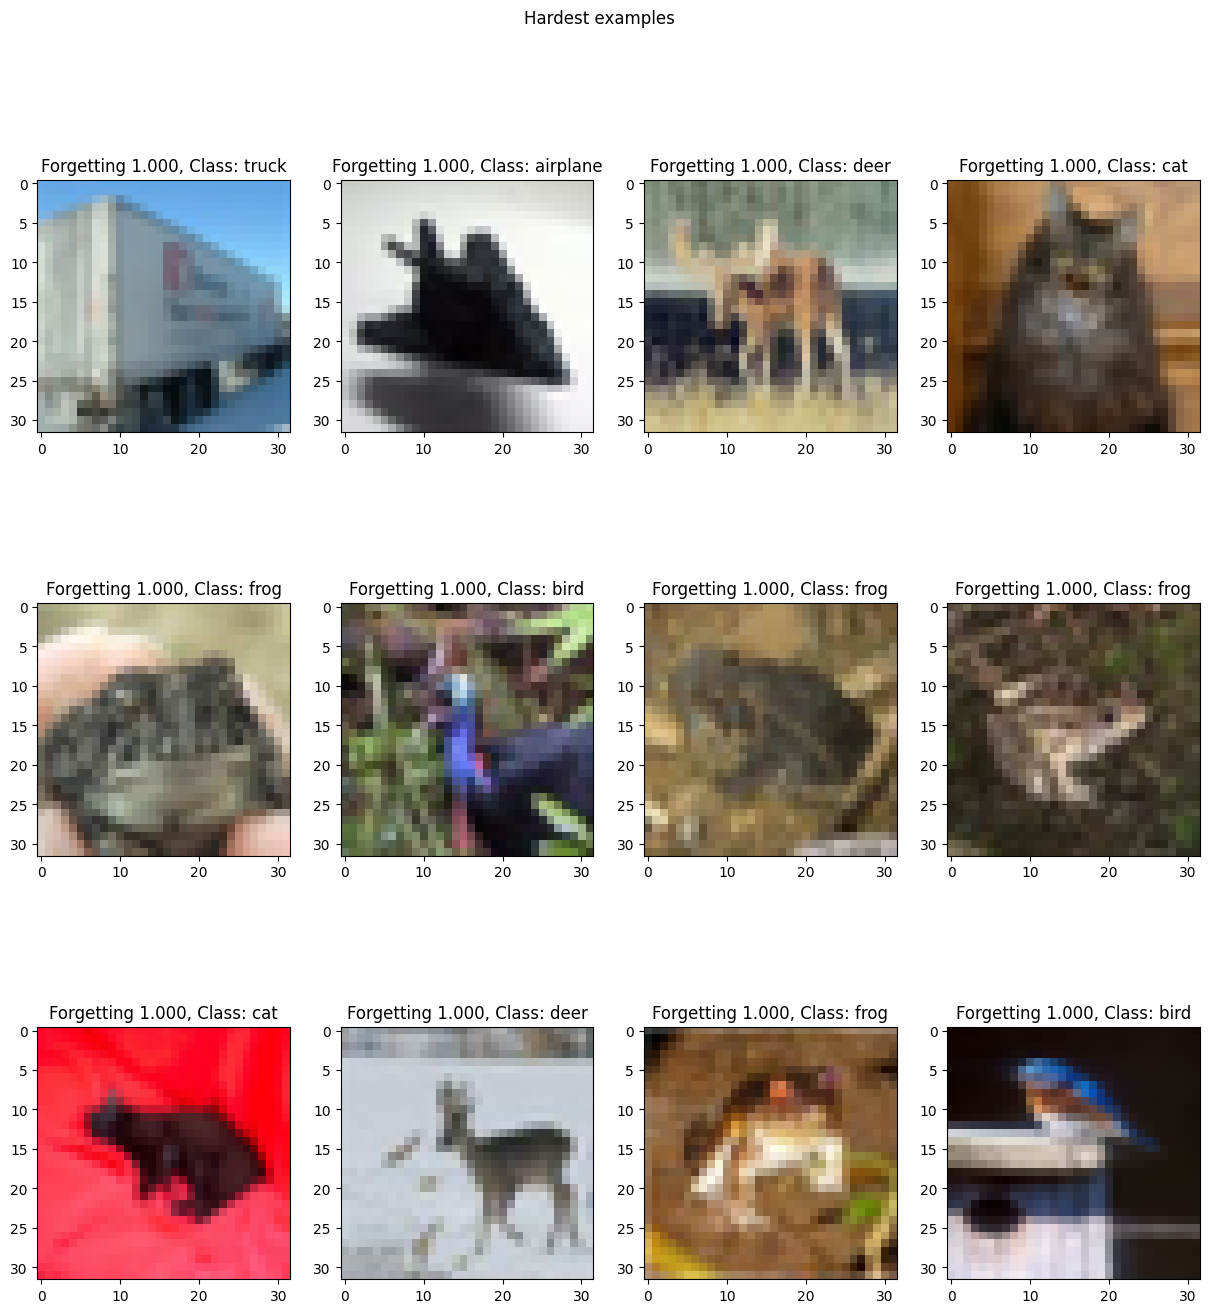

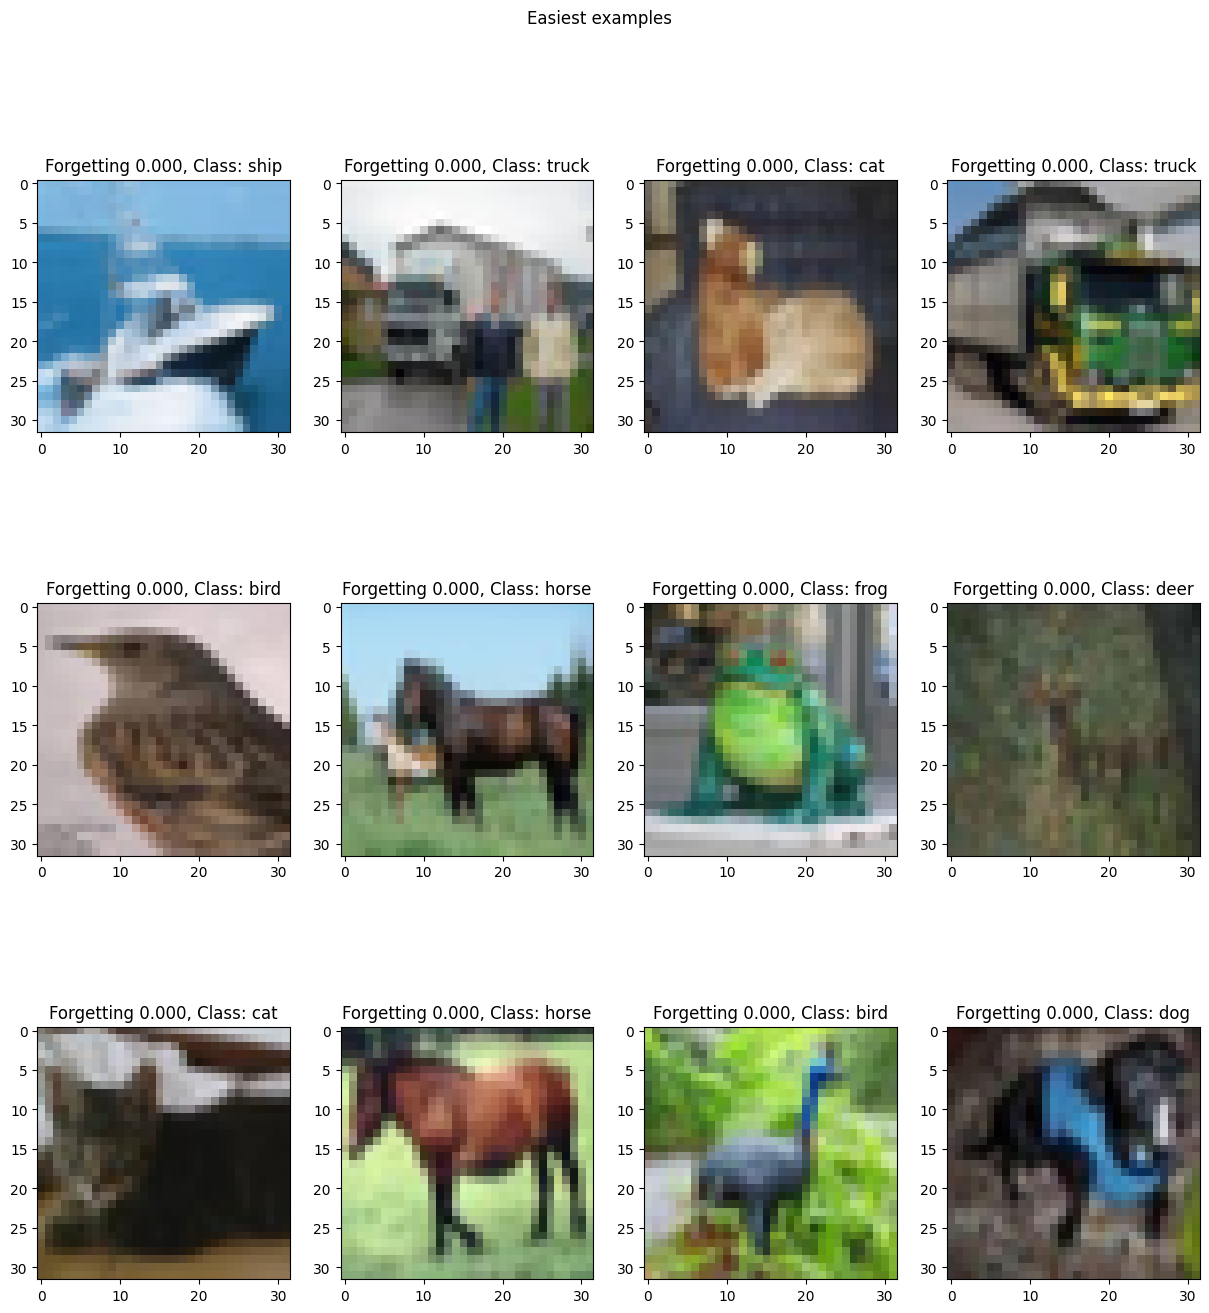

In [18]:
data_train_raw = torchvision.datasets.CIFAR10(os.path.abspath(r'../../../datasets'), train=True)
plot_prune_example(data_train_raw, change_counter, hardest=True, random=False, prune_method_name='Forgetting')
plot_prune_example(data_train_raw, change_counter, hardest=False, random=False, prune_method_name='Forgetting')

## train 2 models: with/without prune and compare the result


run model with prune
Epoch: 0 Training: Loss: 0.504394 Acc: 0.100000  Validation Loss: 0.460639 Acc: 0.050000
Validation loss decreased (inf --> 0.460639).  Saving model to /home/bb/Documents/Data-pruning/code/models_data/el2n_resnet18_cifar10/resnet18_prune
Epoch: 1 Training: Loss: 0.458537 Acc: 0.166667  Validation Loss: 0.472249 Acc: 0.100000
Test Loss: 0.483151
Accuracy: 0.0

run model without prune
Epoch: 0 Training: Loss: 0.479302 Acc: 0.166667  Validation Loss: 0.457065 Acc: 0.150000
Validation loss decreased (inf --> 0.457065).  Saving model to /home/bb/Documents/Data-pruning/code/models_data/el2n_resnet18_cifar10/resnet18_no_prune
Epoch: 1 Training: Loss: 0.477748 Acc: 0.066667  Validation Loss: 0.458004 Acc: 0.150000
Test Loss: 0.467232
Accuracy: 0.05000000074505806


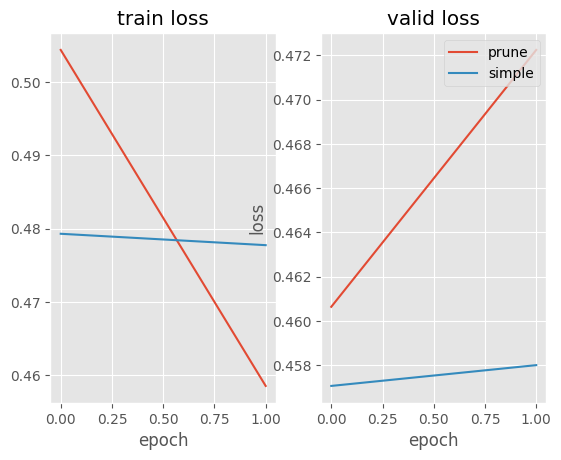

In [19]:
_, idx_to_keep = change_counter.sort(descending=True)[:int(len(change_counter * .5))]

# train model with prune
print("\nrun model with EL2N prune")
loader_train_prune = get_loader(data_train, idx_to_keep, BATCH_SIZE, True)
model_prune, criterion_prune, optimizer_prune = get_model_resnet18_cifar10()
res_train_p, res_valid_p, _ = \
    train(model_prune, loader_train_prune, loader_valid, loader_test, criterion_prune, optimizer_prune, EPOCHS,
          NUM_CLASSES, DEVICE, verbose=True, save_path=PATH_MODELS_SAVE('resnet18_prune'))
scores_train_p, pred_train_p, loss_train_p, acc_train_p = res_train_p
scores_valid_p, pred_valid_p, loss_valid_p, acc_valid_p = res_valid_p

# train model without prune
print("\nrun model without prune")
model_simple, criterion_simple, optimizer_simple = get_model_resnet18_cifar10()
res_train, res_valid, _ = train(model_simple, loader_train, loader_valid, loader_test, criterion_simple,
                                optimizer_simple, EPOCHS, NUM_CLASSES, DEVICE, verbose=True,
                                save_path=PATH_MODELS_SAVE('resnet18_no_prune'))
scores_train, pred_train, loss_train, acc_train = res_train
scores_valid, pred_valid, loss_valid, acc_valid = res_valid

compare_models_losses(loss_train, loss_train_p, loss_valid, loss_valid_p)